In [2]:
import sys
import os
import numpy as np 
import pandas as pd
import numpy.matlib


import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

import torch
import time
import cvxpy as cp
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

## Generate data points $X$

In [3]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Function to generate clustered data
def generate_clusters(total_points, cluster_percentages):
    """
    Generate clustered data based on specified percentages for each cluster.

    :param total_points: Total number of data points to generate.
    :param cluster_percentages: List of percentages for each cluster (should sum to 1).
    :return: Array of generated points.
    """
    # Validate that percentages sum to 1
    if not np.isclose(sum(cluster_percentages), 1.0):
        raise ValueError("Cluster percentages must sum to 1.")

    # Define the cluster centers
    cluster_centers = [(1, 1), (5, 5), (9, 1)]
    
    # Variance of clusters
    cluster_variance = [0.5, 0.3, 0.4]
    
    if len(cluster_percentages) != len(cluster_centers):
        raise ValueError("The number of cluster percentages must match the number of cluster centers.")
    
    # Initialize an empty array for all points
    X = np.empty((0, 2), dtype=float)

    # Generate points for each cluster based on percentages
    for center, variance, percentage in zip(cluster_centers, cluster_variance, cluster_percentages):
        points_per_cluster = int(total_points * percentage)
        # Generate points from a multivariate normal distribution
        points = np.random.multivariate_normal(mean=center, cov=[[variance, 0], [0, variance]], size=points_per_cluster)
        X = np.vstack((X, points))
    
    return X

# Specify the total number of data points
total_points = 300

# Specify the percentages for each cluster (must sum to 1)
cluster_percentages = [0.2, 0.5, 0.3]

# Generate the data
X_init = generate_clusters(total_points, cluster_percentages)


## Regular Clustering Approach 

In [4]:
m = 3
Y = np.mean(X_init,axis = 0)*np.ones((m,2))

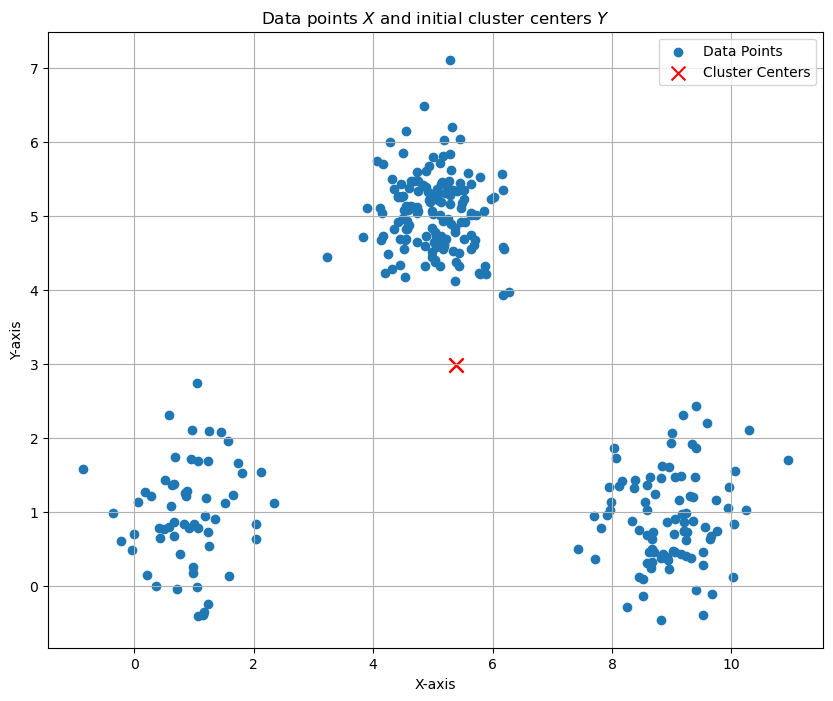

In [5]:
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X_init[:, 0], X_init[:, 1], label='Data Points')
plt.scatter(Y[:, 0], Y[:, 1], color='red', marker='x', s=100, label='Cluster Centers')  # Plot cluster centers
plt.title("Data points $X$ and initial cluster centers $Y$")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()
plt.show() 

In [6]:
def cluster_beta(X_init,Y_init,m,beta,pert):
    N = np.shape(X_init)[0]
    Y_init += pert * (np.arange(m)+1).reshape(-1,1) * np.ones((m,2))
    X_expanded = np.expand_dims(X_init, 1)  # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y_init, 0)       # Shape (1, m, 2)

    # Compute the squared differences, sum over the coordinate axis (axis=2)
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    P_yx = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
    P_xy = P_yx/(np.sum(P_yx, axis = 0).reshape(1,-1))
    Y_c = P_xy.T @ X_init
    return Y_c, P_yx, P_xy

In [7]:
def clustering(X_init,m,pert,beta_final,alpha):
    beta = 0.01
    Y_init = np.mean(X_init,axis = 0)*np.ones((m,2))
    while beta <= beta_final:
        Y, P_yx, P_xy = cluster_beta(X_init,Y_init,m,beta,pert)
        beta *= alpha 
        Y_init = Y
        
    return Y, P_yx

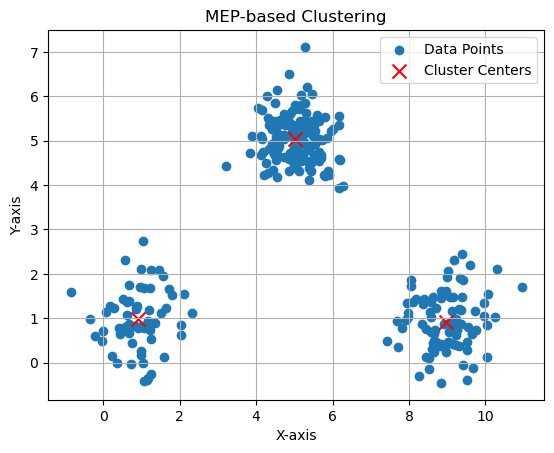

In [8]:
pert = 10e-10
m = 3
beta_final = 0.5
alpha = 1.05
Y_c, P_yx_c = clustering(X_init,m,pert,beta_final,alpha)
plt.scatter(X_init[:,0], X_init[:,1], label='Data Points')
plt.scatter(Y_c[:, 0], Y_c[:, 1], color='red', marker='x', s=100, label='Cluster Centers')  # Plot cluster centers
plt.title(f"MEP-based Clustering")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()
plt.show()

## Free Energy Function and Its Time Derivative

In [9]:
def Gibbs_distribution(X, Y, beta):
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    P_ylx_G = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))

    return P_ylx_G

In [10]:
def Free_Energy(X, Y, q, P_ylx, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    Px = np.diag(q)
    Py = np.sum(Px @ P_ylx, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx, distances + 1/beta * np.log(P_ylx)))

    return F

In [11]:
def Free_Energy_ver2(X, Y, q, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    Px = np.diag(q)
    P_ylx_G = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
    Py = np.sum(Px @ P_ylx_G, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx_G, distances + 1/beta * np.log(P_ylx_G)))

    return F

In [12]:
def F_Fdot_clustering(X, Y, q, P_ylx, u_y, u_p, u_b, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    Px = np.diag(q)
    Py = np.sum(Px @ P_ylx, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx, distances + 1/beta * np.log(P_ylx)))
    F_shifted = F + 1/beta * np.log(m)

    # Time derivatives
    ## w.r.t Y: sum_{j=1}^m (dF/dy_j)^T u_j
    dFdY = 2 * (Py[:, np.newaxis] * Y - P_ylx.T @ Px @ X_init)
    dotF_y = cp.sum(cp.multiply(dFdY,u_y))

    ## w.r.t P_{y|x}: \sum_{i,j} dF/dp_{j|i} v_ij
    dotF_p = cp.sum(cp.multiply(Px @ (distances + 1/beta * np.log(P_ylx) + 1/beta), u_p))

    ## w.r.t beta: (1/beta)^2 H
    dFdb = -1/beta**2 * np.sum(Px @ np.multiply(P_ylx, np.log(P_ylx)))
    dotF_beta = dFdb * u_b

    # Total time derivative
    Fdot = dotF_y + dotF_p + dotF_beta

    return F_shifted, Fdot

In [13]:
def F_Fdot_clustering_ver2(X, Y, q, u_y, u_b, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    Px = np.diag(q)
    P_ylx_G = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
    Py = np.sum(Px @ P_ylx_G, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx_G, distances + 1/beta * np.log(P_ylx_G)))
    F_shifted = F + 1/beta * np.log(m)

    # Time derivatives
    ## w.r.t Y: sum_{j=1}^m (dF/dy_j)^T u_j
    dFdY = 2 * (Py[:, np.newaxis] * Y - P_ylx_G.T @ Px @ X_init)
    dotF_y = cp.sum(cp.multiply(dFdY,u_y))

    ## w.r.t beta: (1/beta)^2 H
    dFdb = -1/beta**2 * np.sum(Px @ np.multiply(P_ylx_G, np.log(P_ylx_G)))
    dotF_beta = dFdb * u_b

    # Total time derivative
    Fdot = dotF_y + dotF_beta

    return F_shifted, Fdot

## Control Barrier Functions

In [14]:
def h_hdot(P_ylx, u_p):
    h = P_ylx * (1 - P_ylx)
    hdot = cp.multiply((1 - 2 * P_ylx), u_p)
    return h, hdot

In [15]:
def l_ldot(c, q, P_ylx, u_p):
    l = c - np.dot(q, P_ylx)
    ldot = - (q[:,np.newaxis].T @ u_p).flatten()
    return l, ldot

## Optimization Step

In [16]:
# Set parameters
N = total_points
q = 1/N * np.ones(N)
Px = np.diag(q)
res = 1e-5

# Fix the random seed for reproducibility
np.random.seed(20)

# Initialization of the decision variables
# Y = np.mean(X_init,axis = 0)*np.ones((m,2)) + res * np.random.rand(m,2)
Y = 10 * np.random.rand(m,2)
# Y = Y_traj[:,:,t]

P_ylx = np.random.rand(N, m)
P_ylx = P_ylx / P_ylx.sum(axis=1, keepdims=True)
# P_ylx = 1/m * np.ones((N,m))
# P_ylx = P_traj[:,:,t]

Py = np.sum(Px @ P_ylx, axis = 0)
c = 10 * np.ones(m) + res

In [17]:
# Check whether the capacity constraint is satisfied

c - Py # all the elements must be non-negative

array([9.65614787, 9.66234245, 9.68153968])

In [18]:
# Decision variables 
u_p = cp.Variable((N,m))
u_y = cp.Variable((m,2))  
delta = cp.Variable(1)
# kappa_y = cp.Variable(1)
# kappa_p = cp.Variable(1)

# Constant parameters of the QP
p = 1000
gamma = 1
alpha_h = 20
alpha_l = 20
u_b = 0
beta = 0.01
coef_uy = 1

# # Define nominal control for Y
# P_xy = P_ylx/(np.sum(P_ylx, axis = 0).reshape(1,-1))
# Y_bar =P_xy.T @ X_init
# u_y_nom = kappa_y * (Y_bar - Y)

# # Define nominal control for P
# X_expanded = np.expand_dims(X_init, 1)  # Shape (N, 1, 2)
# Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
# distances_squared = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
# distances_squared_n = distances_squared - np.min(distances_squared, axis = 1).reshape(-1,1)
# P_ylx_bar = np.exp(-beta * distances_squared_n)/(np.sum(np.exp(-beta * distances_squared_n),axis = 1).reshape(-1,1))
# u_p_nom = kappa_p * (P_ylx_bar - P_ylx)

# Objective: minimize the sum of squares of x and the sum of q
objective = cp.Minimize(cp.sum_squares(u_p) + coef_uy * cp.sum_squares(u_y) + p * delta**2)
# objective = cp.Minimize(cp.sum_squares(u_p - u_p_nom) + coef_uy * cp.sum_squares(u_y - u_y_nom) + p * delta**2)

# Define constraints
F , Fdot = F_Fdot_clustering(X_init, Y, q, P_ylx, u_y, u_p, u_b, beta)
h, h_dot = h_hdot(P_ylx, u_p)
l, l_dot = l_ldot(c, q, P_ylx, u_p)

constraints = [
    Fdot <= -gamma * F + delta,
    cp.sum(u_p, axis=1) == 0,
    h_dot >= -alpha_h * h,
    l_dot >= -alpha_l * l
]

# Define the problem
problem = cp.Problem(objective, constraints)

# Solver Options
solver_options = {
'max_iter': 20000,         # Increase max iterations to 20000
'eps_abs': 1e-4,           # Adjust absolute tolerance
'eps_rel': 1e-4,           # Adjust relative tolerance
'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
'verbose': True            # Enable verbose output to track solver progress
}

# Solve the problem
result = problem.solve(solver = 'OSQP', verbose = 0)
print("Is problem quadratic?", problem.is_qp())

# Print results
print("Status:", problem.status)
print("Optimal value:", problem.value)
print("Optimal u_p:", np.array(u_p.value))
print("Optimal u_y:", np.array(u_y.value))
print("Optimal delta:", np.array(delta.value))
# print("Optimal kappa_y:", np.array(kappa_y.value), ", and optimal kappa_p:", np.array(kappa_p.value))

Is problem quadratic? True
Status: optimal
Optimal value: 38.44658816563108
Optimal u_p: [[ 3.97019847e-02 -6.66102348e-02  2.69082501e-02]
 [ 9.43134425e-02 -1.93397138e-02 -7.49737287e-02]
 [-1.28344271e-02 -8.05893866e-02  9.34238137e-02]
 [ 2.55636838e-01 -5.17014177e-03 -2.50466696e-01]
 [ 6.94792920e-02  1.77554681e-03 -7.12548388e-02]
 [-1.58580162e-01 -1.11425967e-01  2.70006128e-01]
 [-6.19778516e-02 -2.07149457e-02  8.26927973e-02]
 [-9.31880354e-02 -4.20111126e-02  1.35199148e-01]
 [-7.96641766e-02 -1.31009766e-01  2.10673943e-01]
 [ 2.58893382e-01 -2.62580891e-01  3.68750901e-03]
 [ 2.05400738e-04 -1.21819365e-01  1.21613964e-01]
 [ 6.22437565e-02 -1.19016638e-01  5.67728820e-02]
 [-1.70302095e-02 -1.13375703e-01  1.30405912e-01]
 [-9.79474088e-02  8.63930538e-02  1.15543550e-02]
 [-1.32042200e-01  1.31461769e-01  5.80431403e-04]
 [ 7.14070779e-02 -1.11562864e-01  4.01557864e-02]
 [-4.78695226e-02 -4.20535660e-02  8.99230886e-02]
 [-5.89991718e-02 -2.01238764e-02  7.9123048

### Magnitudes of $u_y$ and $u_p$

In [19]:
cp.sum_squares(u_p).value

array(21.68117987)

In [20]:
cp.sum_squares(u_y).value

array(16.76507886)

### Checking the constraints

In [21]:
np.min(h_dot.value + alpha_h * h)

0.49019202041940996

In [22]:
-gamma * F + delta.value - Fdot.value

array([-1.42108547e-14])

In [23]:
l_dot.value + alpha_l * l

array([193.12506212, 193.25455915, 193.62097873])

In [24]:
np.max(np.abs(np.sum(u_p.value, axis=1)))

1.1102230246251565e-16

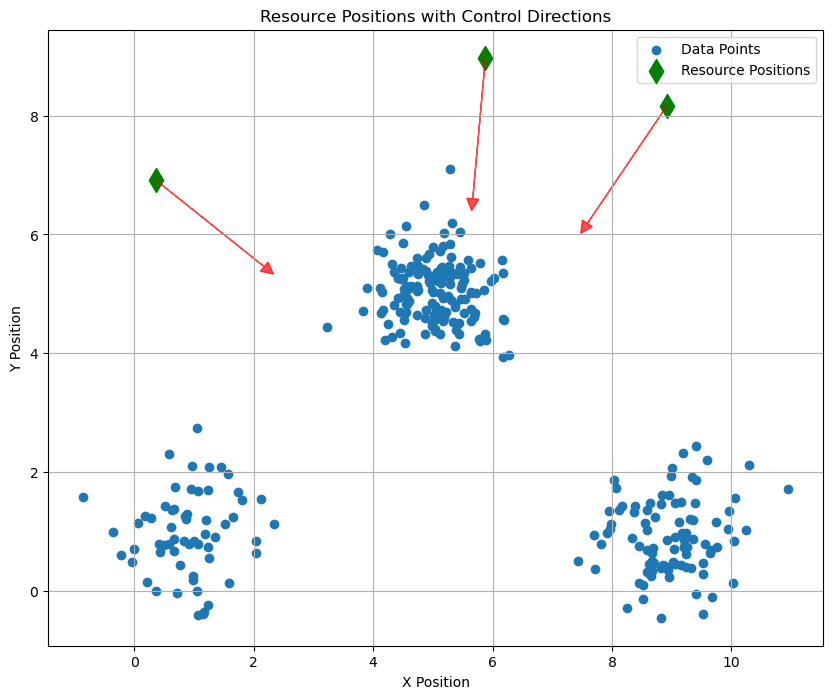

In [25]:
# Normalize the control vectors to have a length of l
l = 1
# u_y_norm = l * u_y.value / np.linalg.norm(u_y.value, axis=1, keepdims=True)
u_y_norm = u_y.value

# Plot resource positions and control arrows
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X_init[:, 0], X_init[:, 1], label='Data Points')
plt.scatter(Y[:, 0], Y[:, 1], color="green", marker='d', s=150, label="Resource Positions")  # Resource positions

# Add arrows for control directions
for i in range(Y.shape[0]):  # Iterate over all resources
    plt.arrow(
        Y[i, 0], Y[i, 1],               # Starting point of the arrow (resource position)
        u_y_norm[i, 0], u_y_norm[i, 1],  # Arrow direction (normalized control vector)
        head_width=0.2, head_length=0.2, fc="red", ec="red", alpha=0.7
    )

# Customize the plot
plt.title("Resource Positions with Control Directions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()


### Vesrion 2 - Control $y_j$

In [60]:
# Set parameters
N = total_points
q = 1/N * np.ones(N)
Px = np.diag(q)
res = 1e-6

# Fix the random seed for reproducibility
np.random.seed(42)

# Initialization of the decision variables
# Y = np.mean(X_init,axis = 0)*np.ones((m,2)) + res * np.random.rand(m,2)
Y = 10 * np.random.rand(m,2)
# Y = Y_test

In [61]:
F , Fdot = F_Fdot_clustering(X_init, Y, q, P_ylx, u_y, u_p, u_b, beta)

In [84]:
# Decision variables 
u_y_v2 = cp.Variable((m,2))  
delta_v2 = cp.Variable(1)

# Constant parameters of the QP
p = 1000
gamma = 1
u_b = 0
beta = 7

# Objective: minimize the sum of squares of x and the sum of q
objective_v2 = cp.Minimize(cp.sum_squares(u_y_v2) + p * delta_v2**2)

# Define constraints
F_v2 , Fdot_v2 = F_Fdot_clustering_ver2(X_init, Y, q, u_y_v2, u_b, beta)

constraints_v2 = [
    Fdot_v2 <= -gamma * F_v2 + delta_v2,
]

# Define the problem
problem_v2 = cp.Problem(objective_v2, constraints_v2)

# Solver Options
solver_options = {
'max_iter': 20000,         # Increase max iterations to 20000
'eps_abs': 1e-4,           # Adjust absolute tolerance
'eps_rel': 1e-4,           # Adjust relative tolerance
'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
'verbose': True            # Enable verbose output to track solver progress
}

# Solve the problem
result_v2 = problem_v2.solve(solver = 'OSQP', verbose = 0)
print("Is problem quadratic?", problem.is_qp())

# Print results
print("Status:", problem_v2.status)
print("Optimal value:", problem_v2.value)
print("Optimal u_y:", np.array(u_y_v2.value))
print("Optimal delta:", np.array(delta_v2.value))

Is problem quadratic? True
Status: optimal
Optimal value: 9.009906007300529
Optimal u_y: [[ 4.84758535e-11 -7.69739446e-11]
 [-9.09189858e-01 -2.85091984e+00]
 [-1.77627369e-01 -1.53208451e-01]]
Optimal delta: [0.00071526]


In [85]:
-gamma * F_v2 + delta_v2.value - Fdot_v2.value

array([0.])

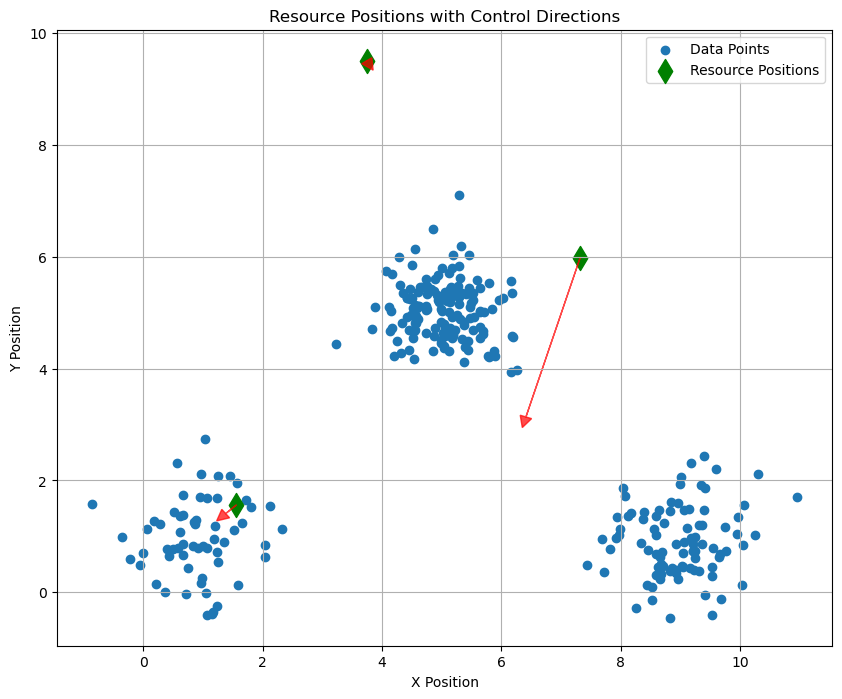

In [86]:
# Normalize the control vectors to have a length of l
l = 1
# u_y_norm = l * u_y_v2.value / np.linalg.norm(u_y_v2.value, axis=1, keepdims=True)
u_y_norm = u_y_v2.value

# Plot resource positions and control arrows
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X_init[:, 0], X_init[:, 1], label='Data Points')
plt.scatter(Y[:, 0], Y[:, 1], color="green", label="Resource Positions", s=150, marker="d")

# Add arrows for control directions
for i in range(Y.shape[0]):  # Iterate over all resources
    plt.arrow(
        Y[i, 0], Y[i, 1],               # Starting point of the arrow (resource position)
        u_y_norm[i, 0], u_y_norm[i, 1],  # Arrow direction (normalized control vector)
        head_width=0.2, head_length=0.2, fc="red", ec="red", alpha=0.7
    )

# Customize the plot
plt.title("Resource Positions with Control Directions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
u_y_v2.value

array([[ 4.84758535e-11, -7.69739446e-11],
       [-9.09189858e-01, -2.85091984e+00],
       [-1.77627369e-01, -1.53208451e-01]])

### Controller

In [88]:
def control_dyn_ver3(X, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l):
    # Decision variables 
    u_p = cp.Variable((N,m))
    u_y = cp.Variable((m,2))  
    # u_y = cp.Parameter((m,2))
    # u_y.value = np.zeros((m,2))
    delta = cp.Variable(1)
    kappa_y = cp.Variable(1)
    kappa_p = cp.Variable(1)
    coef_uy = 1

    # Define nominal control for Y
    P_xy = P_ylx/(np.sum(P_ylx, axis = 0).reshape(1,-1))
    Y_bar =P_xy.T @ X_init
    u_y_nom = kappa_y * (Y_bar - Y)

    # Define nominal control for P
    X_expanded = np.expand_dims(X, 1)  # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances_squared = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    distances_squared_n = distances_squared - np.min(distances_squared, axis = 1).reshape(-1,1)
    P_ylx_bar = np.exp(-beta * distances_squared_n)/(np.sum(np.exp(-beta * distances_squared_n),axis = 1).reshape(-1,1))
    u_p_nom = kappa_p * (P_ylx_bar - P_ylx)

    # Objective: minimize the sum of squares of x and the sum of q
    objective = cp.Minimize(cp.sum_squares(u_p - u_p_nom) + coef_uy * cp.sum_squares(u_y - u_y_nom) + p * delta**2)
    # objective = cp.Minimize(cp.sum_squares(u_p - u_p_nom)  + p * delta**2)

    # Define constraints
    F , Fdot = F_Fdot_clustering(X_init, Y, q, P_ylx, u_y, u_p, u_b, beta)
    h, h_dot = h_hdot(P_ylx, u_p)
    # l, l_dot = l_ldot(c, q, P_ylx, u_p)

    constraints = [
        Fdot <= -gamma * F + delta,
        cp.sum(u_p, axis=1) == 0,
        h_dot >= -alpha_h * h,
        # l_dot >= -alpha_l * l
    ]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solver Options
    solver_options = {
    'max_iter': 20000,         # Increase max iterations to 20000
    'eps_abs': 1e-4,           # Adjust absolute tolerance
    'eps_rel': 1e-4,           # Adjust relative tolerance
    'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
    'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
    'verbose': True            # Enable verbose output to track solver progress
    }

    # Solve the problem
    result = problem.solve(solver = 'OSQP', verbose = 0)
    
    # Check the results
    if np.isnan(problem.value).any() == True:
        print("Nan encountered!")
        return np.zeros((N,m)), np.zeros((m,2))
    else:         
        return u_p.value, u_y.value, F, Fdot.value

In [89]:
def control_dyn(X, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l):
    # Decision variables 
    u_p = cp.Variable((N,m))
    u_y = cp.Variable((m,2))  
    # u_y = cp.Parameter((m,2))
    # u_y.value = np.zeros((m,2))
    delta = cp.Variable(1)

    ## Constant parameters of the QP
    # p = 1000
    # gamma = 1
    # alpha_h = 10
    #alpha_l = 10

    # Objective: minimize the sum of squares of x and the sum of q
    objective = cp.Minimize(cp.sum_squares(u_p) + cp.sum_squares(u_y) + p * delta**2)

    # Define constraints
    F , Fdot = F_Fdot_clustering(X, Y, q, P_ylx, u_y, u_p, u_b, beta)
    h, h_dot = h_hdot(P_ylx, u_p)
    l, l_dot = l_ldot(c, q, P_ylx, u_p)

    constraints = [
        Fdot <= -gamma * F + delta,
        cp.sum(u_p, axis=1) == 0,
        h_dot >= -alpha_h * h,
        l_dot >= -alpha_l * l
    ]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solver Options
    solver_options = {
    'max_iter': 20000,         # Increase max iterations to 20000
    'eps_abs': 1e-4,           # Adjust absolute tolerance
    'eps_rel': 1e-4,           # Adjust relative tolerance
    'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
    'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
    'verbose': True            # Enable verbose output to track solver progress
    }

    # Solve the problem
    result = problem.solve(solver = 'OSQP', verbose = 0)
    
    # Check the results
    if np.isnan(problem.value).any() == True:
        print("Nan encountered!")
        return np.zeros((N,m)), np.zeros((m,2))
    else:         
        return u_p.value, u_y.value, F, Fdot.value

In [90]:
# This version is for debugging and includes constraint values 
def control_dyn_debug(X, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l):
    # Decision variables 
    u_p = cp.Variable((N,m))
    # u_y = cp.Variable((m,2))  
    u_y = cp.Parameter((m,2))
    u_y.value = np.zeros((m,2))
    delta = cp.Variable(1)

    ## Constant parameters of the QP
    # p = 1000
    # gamma = 1
    # alpha_h = 10
    #alpha_l = 10

    # Objective: minimize the sum of squares of x and the sum of q
    objective = cp.Minimize(cp.sum_squares(u_p) + cp.sum_squares(u_y) + p * delta**2)

    # Define constraints
    F , Fdot = F_Fdot_clustering(X, Y, q, P_ylx, u_y, u_p, u_b, beta)
    h, h_dot = h_hdot(P_ylx, u_p)
    l, l_dot = l_ldot(c, q, P_ylx, u_p)

    constraints = [
        Fdot <= -gamma * F + delta,
        cp.sum(u_p, axis=1) == 0,
        h_dot >= -alpha_h * h,
        l_dot >= -alpha_l * l
    ]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve(solver = 'OSQP', verbose = 0)

    # Solver Options
    solver_options = {
    'max_iter': 20000,         # Increase max iterations to 20000
    'eps_abs': 1e-4,           # Adjust absolute tolerance
    'eps_rel': 1e-4,           # Adjust relative tolerance
    'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
    'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
    'verbose': True            # Enable verbose output to track solver progress
    }
    
    # Check the results
    if np.isnan(problem.value).any() == True:
        print("Nan encountered!")
        return np.zeros((N,m)), np.zeros((m,2))
    else:         
        return u_p.value, u_y.value, F, Fdot.value, h, h_dot.value, l, l_dot.value, delta.value

In [91]:
def control_dyn_ver2(X, Y, q, beta, u_b, p, gamma):
    # Decision variables 
    u_y_v2 = cp.Variable((m,2))  
    delta_v2 = cp.Variable(1)

    # Constant parameters of the QP
    # p = 1000
    # gamma = 1
    # u_b = 0
    # beta = 10

    # Objective: minimize the sum of squares of x and the sum of q
    objective_v2 = cp.Minimize(cp.sum_squares(u_y_v2) + p * delta_v2**2)

    # Define constraints
    F_v2 , Fdot_v2 = F_Fdot_clustering_ver2(X_init, Y, q, u_y_v2, u_b, beta)

    constraints_v2 = [
        Fdot_v2 <= -gamma * F_v2 + delta_v2,
    ]

    # Define the problem
    problem_v2 = cp.Problem(objective_v2, constraints_v2)

    # Solver Options
    solver_options = {
    'max_iter': 20000,         # Increase max iterations to 20000
    'eps_abs': 1e-4,           # Adjust absolute tolerance
    'eps_rel': 1e-4,           # Adjust relative tolerance
    'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
    'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
    'verbose': True            # Enable verbose output to track solver progress
    }

    # Solve the problem
    result_v2 = problem_v2.solve(solver = 'OSQP', verbose = 0)
    
    # Check the results
    if np.isnan(problem_v2.value).any() == True:
        print("Nan encountered!")
        return np.zeros((m,2))
    else:         
        return u_y_v2.value

## Numerical simulation

In [92]:
# Auxiliary functions to project back into the feasible space
def project_to_stochastic_matrix(matrix):
    """
    Projects each row of the input matrix onto the simplex (triangle) defined by:
    - The row sums to 1
    - Each element in the row lies within [0, 1]

    :param matrix: np.ndarray, the input matrix (shape: NxM)
    :return: np.ndarray, the projected matrix (same shape as input)
    """
    def project_to_plane(vector):
        N = vector.shape[0]
        normal = np.ones((N,))
        p = 1 / N * np.ones((N,))
        n_dot_n = N
        v_dot_n = np.dot(vector, normal)
        p_dot_n = np.dot(p, normal)
        projection = vector - ((v_dot_n - p_dot_n) / n_dot_n) * normal
        return projection

    def project_to_triangle(v):
        tol = 1e-7
        v_proj = project_to_plane(v)
        v_clamped = np.clip(v_proj, tol, 1 - tol)
        sum_clamped = np.sum(v_clamped)

        if sum_clamped == 1:
            return v_clamped
        elif sum_clamped < 1:
            deficit = 1 - sum_clamped
            free_indices = v_clamped < 1
            num_free = np.sum(free_indices)
            if num_free > 0:
                increment = deficit / num_free
                v_clamped[free_indices] += increment
            return v_clamped
        else:
            return v_clamped / sum_clamped

    # Apply the projection to each row of the matrix
    projected_matrix = np.apply_along_axis(project_to_triangle, axis=1, arr=matrix)
    return projected_matrix

In [93]:
# Fix the random seed for reproducibility
np.random.seed(4)

# Simulation parameters
T_f = 5 # Total time
dt = 0.01  # Time step
times = np.arange(0, T_f, dt)  # Time vector
Y_traj = np.zeros((m,2,len(times)))
P_traj = np.zeros((N,m,len(times)))
u_y_traj = np.zeros((m,2,len(times)))
u_p_traj = np.zeros((N,m,len(times)))
beta_traj = np.zeros(len(times))

q = 1/N * np.ones(N)
Px = np.diag(q)
pert = 1e-6

# Initialization of the decision variables
# Y0 = np.mean(X_init,axis = 0)*np.ones((m,2))
# Y = Y0 + pert * np.random.rand(m,2)
# Y = 10 * np.random.rand(m,2)
Y = np.ones((m,2))
# Y = Y_traj[:,:,t]

P_ylx = np.random.rand(N, m)
P_ylx = P_ylx / P_ylx.sum(axis=1, keepdims=True)
# P_ylx = 1/m * np.ones((N,m))
# P_ylx = P_traj[:,:,t]

Py = np.sum(Px @ P_ylx, axis = 0)
c = 0.4 * np.ones(m) + pert

# Setting the coefficients
alpha_h = 20
alpha_l = 20
p = 1000
gamma = 1
beta = 0.2
u_b = 1

run_time_cvx = []
print('beta = ', beta)

beta =  0.2


In [94]:
u_p, u_y, F, Fdot, h, hdot, l, ldot, delta = control_dyn_debug(X_init, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l)
print("Ineq Constraint 1 - Elements between 0 and 1: ", np.min(hdot + alpha_h * h))
print("Ineq Constraint 2 - Capacity constraint: ", np.min(ldot + alpha_l * l))
print("Ineq Constraint 3 - Stability: ", -gamma * F + delta - Fdot)
print("Eq Constraint 4 - Rows of u_p must sum up to 0: ", np.max(np.abs(np.sum(u_p, axis=1))))

Ineq Constraint 1 - Elements between 0 and 1:  -1.1102230246251565e-16
Ineq Constraint 2 - Capacity constraint:  1.2729084808358304
Ineq Constraint 3 - Stability:  [7.10542736e-14]
Eq Constraint 4 - Rows of u_p must sum up to 0:  5.329070518200751e-15


In [95]:
# Simulate the system
tol = 10e-15
Free_energy = []
Fdot_array = []
beta_array = []

for t in range(len(times)):  # start from 1 because 0 is initial condition
    # Store the state
    Y_traj[:,:,t] = Y
    P_traj[:,:,t] = P_ylx
    
    # Free_energy.append(Free_Energy(X_init, Y, q, P_ylx, beta)) # Store the free energy at each time
    
    start_time = time.time()
    u_p, u_y, F_b, Fdot_b = control_dyn(X_init, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l)
    end_time = time.time()
    u_p_traj[:,:,t], u_y_traj[:,:,t] = u_p, u_y
    Free_energy.append(F_b)
    Fdot_array.append(Fdot_b)
    run_time_cvx.append(end_time - start_time)
    beta_array.append(beta)
    
    Y += u_y * dt  # Update Y
    P_ylx += u_p * dt  # Update P
    P_ylx = project_to_stochastic_matrix(P_ylx) # project into the feasible set
    beta += u_b * dt

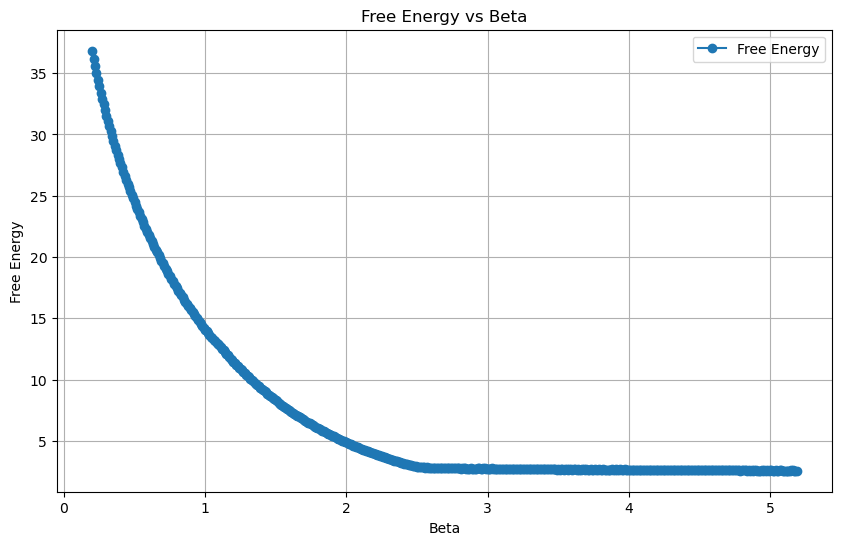

In [96]:
# Plot Free Energy vs. Beta
plt.figure(figsize=(10, 6))
plt.plot(beta_array, Free_energy, marker='o', label='Free Energy')
plt.title("Free Energy vs Beta")
plt.xlabel("Beta")
plt.ylabel("Free Energy")
plt.grid(True)
plt.legend()
plt.show()

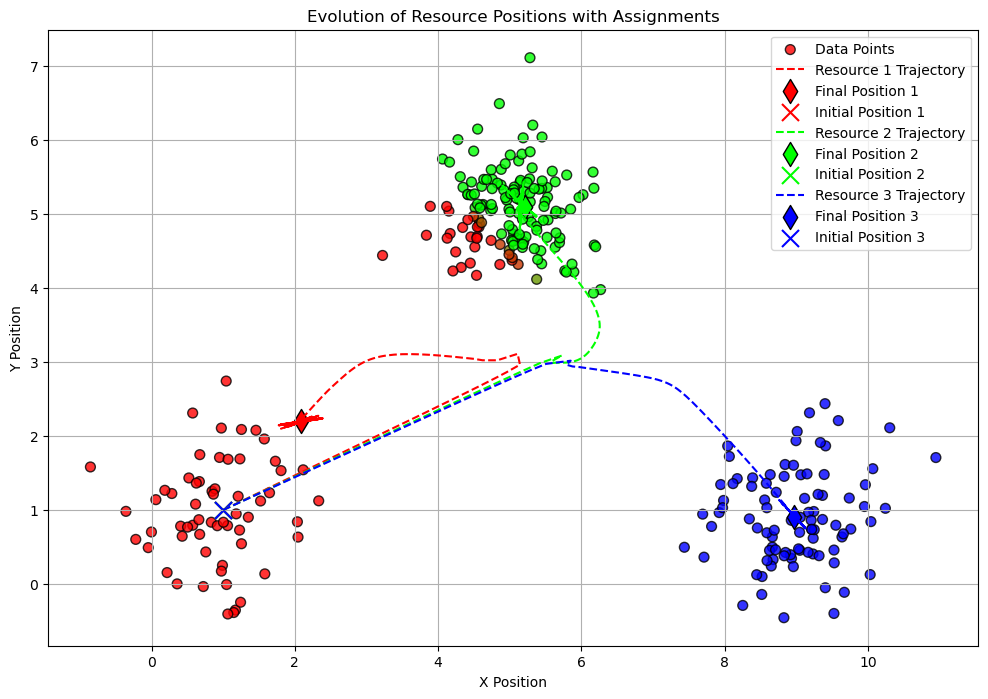

In [97]:
# Define a color for each resource (RGB values)
resource_colors = np.array([
    [1, 0, 0],  # Red for resource 1
    [0, 1, 0],  # Green for resource 2
    [0, 0, 1],  # Blue for resource 3
])

# Compute colors for each data point
data_colors = np.dot(P_ylx, resource_colors)  # Weighted sum of resource colors

# Plot setup
plt.figure(figsize=(12, 8))

# Plot data points with computed colors
plt.scatter(
    X_init[:, 0], X_init[:, 1],
    c=data_colors, s=50, edgecolor='k', alpha=0.8, label="Data Points"
)

# Plot trajectories and final positions of resources
for i in range(m):
    plt.plot(
        Y_traj[i, 0, :], Y_traj[i, 1, :],
        label=f"Resource {i+1} Trajectory", linestyle="--", color=resource_colors[i]
        # color = 'k'
    )
    # Mark final positions of resources
    plt.scatter(
        Y_traj[i, 0, -1], Y_traj[i, 1, -1],
        marker="d", s=150, color=resource_colors[i], edgecolor='k', alpha=1, label=f"Final Position {i+1}"
    )
    plt.scatter(
        Y_traj[i, 0, 0], Y_traj[i, 1, 0],
        marker="x", s=150, color=resource_colors[i], label=f"Initial Position {i+1}"
    )

# Customize the plot
plt.title("Evolution of Resource Positions with Assignments")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()

In [98]:
Py = np.sum(Px @ P_ylx, axis = 0)
print(Py)

[0.29995941 0.40000115 0.30003945]


In [163]:
print('Final free energy value: ', Free_energy[-1])

Final free energy value:  2.5678831958512096


In [100]:
Y_traj[:,:,-1]

array([[2.0923499 , 2.19619419],
       [5.21882999, 5.09476863],
       [8.97323246, 0.91145956]])

In [101]:
P_traj[:,:,-1]

array([[9.99999794e-01, 1.06151879e-07, 9.99999925e-08],
       [9.99999781e-01, 1.19495146e-07, 9.99999916e-08],
       [9.99999794e-01, 1.06129486e-07, 9.99999917e-08],
       [9.99999788e-01, 1.12390826e-07, 9.99999932e-08],
       [9.99999787e-01, 1.12684503e-07, 9.99999909e-08],
       [9.99999796e-01, 1.04484934e-07, 9.99999915e-08],
       [9.99999800e-01, 9.99999925e-08, 9.99999925e-08],
       [9.99999795e-01, 1.05006336e-07, 9.99999901e-08],
       [9.99999789e-01, 1.11391783e-07, 9.99999904e-08],
       [9.99999800e-01, 9.99999913e-08, 9.99999913e-08],
       [9.99999796e-01, 1.04442949e-07, 9.99999940e-08],
       [9.99999800e-01, 9.99999924e-08, 9.99999924e-08],
       [9.99999791e-01, 1.09254597e-07, 9.99999911e-08],
       [9.99999788e-01, 1.12034166e-07, 9.99999902e-08],
       [9.99999794e-01, 1.06041204e-07, 9.99999913e-08],
       [9.99999777e-01, 1.23464088e-07, 9.99999899e-08],
       [9.99999800e-01, 9.99999924e-08, 9.99999924e-08],
       [9.99999800e-01, 9.99999

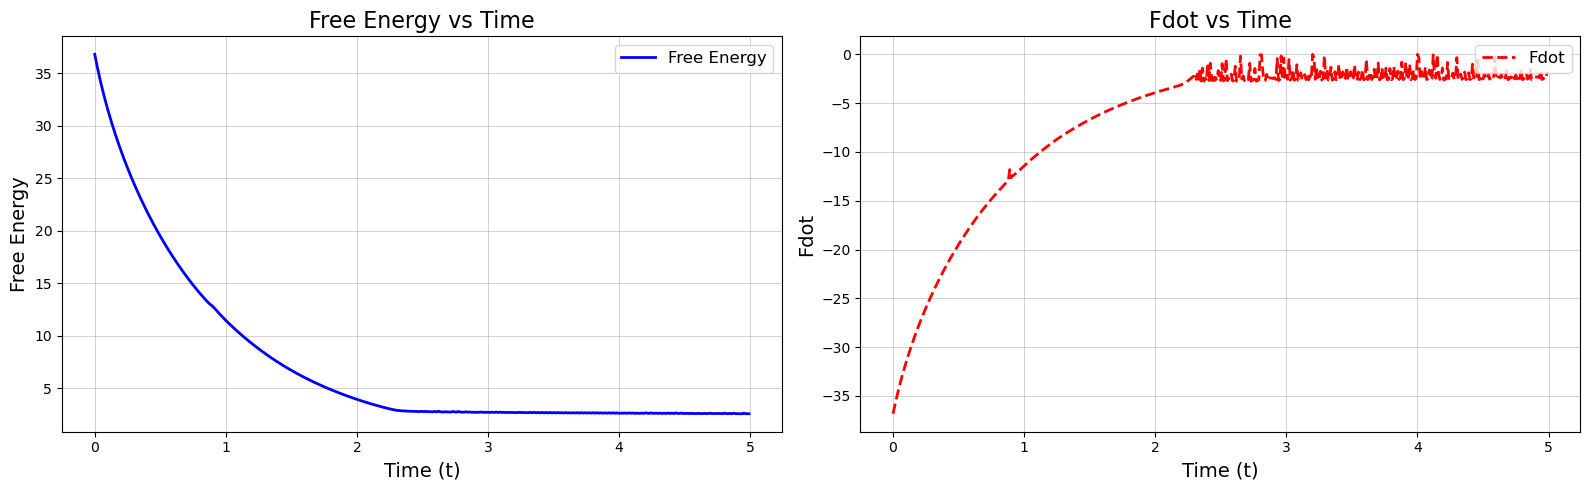

In [102]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16,5))  # Two subplots, one column

# Plot Free Energy vs. Time in the first subplot
axs[0].plot(
    times, Free_energy,
    color="blue", linestyle="-", linewidth=2, label="Free Energy"
)
axs[0].set_title("Free Energy vs Time", fontsize=16)
axs[0].set_xlabel("Time (t)", fontsize=14)
axs[0].set_ylabel("Free Energy", fontsize=14)
axs[0].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.5)
axs[0].legend(fontsize=12, loc="upper right")

# Plot Fdot vs. Time in the second subplot
axs[1].plot(
    times, Fdot_array,
    color="red", linestyle="--", linewidth=2, label="Fdot"
)
axs[1].set_title("Fdot vs Time", fontsize=16)
axs[1].set_xlabel("Time (t)", fontsize=14)
axs[1].set_ylabel("Fdot", fontsize=14)
axs[1].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.5)
axs[1].legend(fontsize=12, loc="upper right")

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

### ODE Solver

In [120]:
def dynamics(z, X_init, q, u_b, p, gamma, alpha_h, alpha_l, N, m):
    """
    Computes the time derivative of the state.
    
    Parameters:
      t       : time (not used explicitly here, but required by solve_ivp)
      z       : flattened state vector [Y.flatten(), P.flatten(), beta]
      X_init  : initial parameter or state used in control_dyn
      q, u_b, p, gamma, alpha_h, alpha_l : additional parameters for control_dyn
      N       : mumber of data poits
      m       : number of facilities
      
    Returns:
      dz/dt  : flattened derivative vector.
    """
    # Unpack the state vector
    n_Y = m * 2
    n_P = N * m
    Y = z[0:n_Y].reshape(m,2)
    P = z[n_Y:n_Y+n_P].reshape(N,m)
    beta = z[-1]

    # Compute control inputs; control_dyn should return u_p and u_y for state evolution.
    u_p, u_y, F_b, Fdot_b = control_dyn(X_init, Y, q, P, beta, u_b, p, gamma, alpha_h, alpha_l)
    
    # Compute the derivatives
    dY_dt = u_y           # dY/dt = u_y
    dP_dt = u_p           # dP/dt = u_p
    d_beta_dt = u_b       # d(beta)/dt = u_b (assuming u_b is given)

    # P_projected = project_to_stochastic_matrix(P)
    
    # Flatten the derivatives into a single vector
    dzdt = np.concatenate([dY_dt.flatten(), dP_dt.flatten(), np.array([d_beta_dt])])
    return dzdt, Fdot_b

In [123]:
def euler_forward(dynamics, z0, X_init, q, u_b, p, gamma, alpha_h, alpha_l, N, m, T_f, dt, tol=1e-2):
    """
    Forward Euler integration with projection step for P.
    Breaks loop early if abs(Fdot) falls below tol.

    Parameters:
      dynamics : function returning dz/dt
      z0       : initial state
      T_f      : final time
      dt       : time step
      tol      : stopping criterion for abs(Fdot)
      
    Returns:
      times    : time points
      traj     : array of state trajectory
    """
    num_steps = int(T_f / dt)
    traj = np.zeros((num_steps + 1, len(z0)))
    times = np.zeros(num_steps + 1)

    traj[0] = z0
    times[0] = 0.0

    for i in range(num_steps):
        z = traj[i]

        # Compute time derivative
        dzdt, Fdot = dynamics(z, X_init, q, u_b, p, gamma, alpha_h, alpha_l, N, m)

        # Break loop if |Fdot| is too small
        if abs(Fdot) < tol:
            print(f"Terminating early at step {i}, time {times[i]:.4f} because abs(Fdot)={abs(Fdot):.6f} < tol={tol}")
            return times[:i+1], traj[:i+1]  # Return only computed values

        # Euler update
        z_next = z + dt * dzdt

        # Projection step for P
        n_Y = m * 2
        n_P = N * m
        Y_next = z_next[:n_Y].reshape(m, 2)
        P_next = z_next[n_Y:n_Y+n_P].reshape(N, m)
        beta_next = z_next[-1]

        # Apply projection to P
        P_projected = project_to_stochastic_matrix(P_next)

        # Reassemble state with projected P
        z_projected = np.concatenate([Y_next.flatten(), P_projected.flatten(), np.array([beta_next])])

        # Store projected state
        traj[i+1] = z_projected
        times[i+1] = times[i] + dt  # Store time

    return times, traj

In [158]:
# Initialization of the decision variables
# Y0 = np.mean(X_init,axis = 0)*np.ones((m,2))
# Y0 = Y0 + pert * np.random.rand(m,2)
# Y0 = 10 * np.random.rand(m,2)
Y0 = np.ones((m,2))

P0 = np.random.rand(N, m)
P0 = P0 / P0.sum(axis=1, keepdims=True)
# P0 = 1/m * np.ones((N,m))

Py = np.sum(Px @ P0, axis = 0)
c = 0.4 * np.ones(m) + pert

# Setting the coefficients
alpha_h = 20
alpha_l = 20
p = 1000
gamma = 1
beta = 0.2
u_b = 1
z0 = np.concatenate([Y0.flatten(), P0.flatten(), np.array([beta])])

In [159]:
T_f = 5
dt = 0.005
times, sol_traj = euler_forward(dynamics, z0, X_init, q, u_b, p, gamma, alpha_h, alpha_l, N, m, T_f, dt, tol=0.05)

Terminating early at step 645, time 3.2250 because abs(Fdot)=0.021914 < tol=0.05


In [160]:
# Extract trajectory components from sol_traj
num_steps = sol_traj.shape[0]
n_Y = m * 2  # Y has shape (m, 2)
n_P = N * m  # P has shape (N, m)

Y_traj = sol_traj[:, :n_Y].reshape(num_steps, m, 2)  # (timesteps, m, 2)
P_traj = sol_traj[:, n_Y:n_Y+n_P].reshape(num_steps, N, m)  # (timesteps, N, m)
beta_traj = sol_traj[:, -1]  # (timesteps,)

In [165]:
print('Final free energy value: ', Free_Energy(X_init, Y_traj[-1,:,:],q, P_traj[-1,:,:], beta_traj[-1]))

Final free energy value:  2.351997938830917


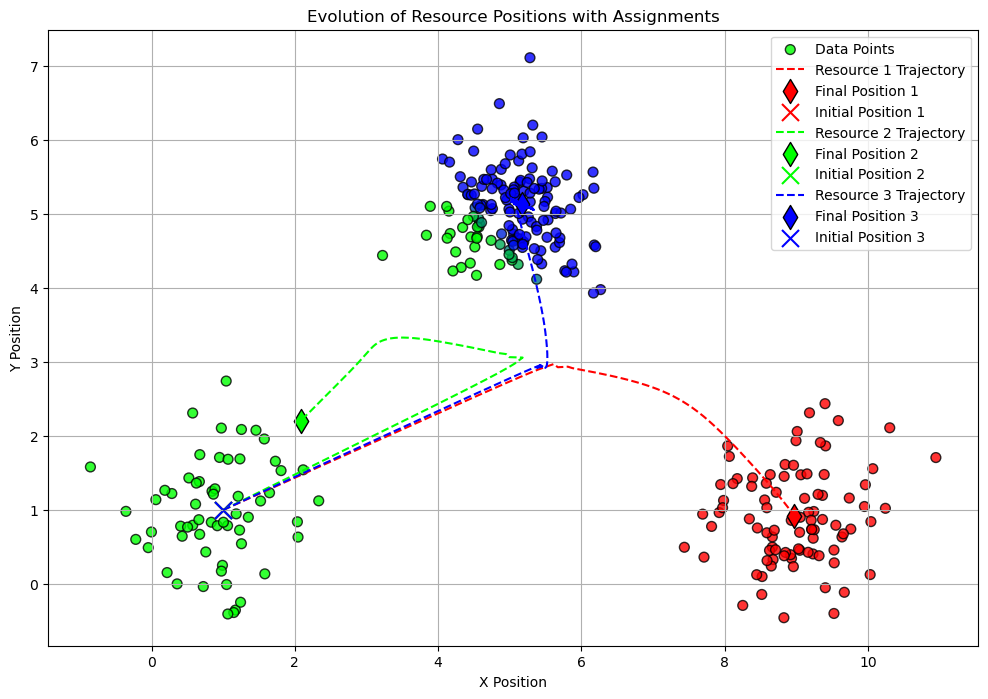

In [162]:
# Define a color for each resource (RGB values)
resource_colors = np.array([
    [1, 0, 0],  # Red for resource 1
    [0, 1, 0],  # Green for resource 2
    [0, 0, 1],  # Blue for resource 3
])

# Plot setup
plt.figure(figsize=(12, 8))

# Compute colors for each data point at the final time step
data_colors = np.dot(P_traj[-1], resource_colors)  # Weighted sum of resource colors at final step

# Plot data points with computed colors
plt.scatter(
    X_init[:, 0], X_init[:, 1],
    c=data_colors, s=50, edgecolor='k', alpha=0.8, label="Data Points"
)

# Plot trajectories and final positions of resources
for i in range(m):
    plt.plot(
        Y_traj[:, i, 0], Y_traj[:, i, 1],  # Extract trajectory over time for resource i
        label=f"Resource {i+1} Trajectory", linestyle="--", color=resource_colors[i]
    )

    # Mark final positions of resources
    plt.scatter(
        Y_traj[-1, i, 0], Y_traj[-1, i, 1],
        marker="d", s=150, color=resource_colors[i], edgecolor='k', alpha=1, label=f"Final Position {i+1}"
    )

    # Mark initial positions of resources
    plt.scatter(
        Y_traj[0, i, 0], Y_traj[0, i, 1],
        marker="x", s=150, color=resource_colors[i], label=f"Initial Position {i+1}"
    )

# Customize the plot
plt.title("Evolution of Resource Positions with Assignments")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()

### Version 2 - Control $y_j$

In [1399]:
# Fix the random seed for reproducibility
np.random.seed(17)

# Simulation parameters
T_f = 5 # Total time
dt = 0.001  # Time step
times = np.arange(0, T_f, dt)  # Time vector
Y_traj = np.zeros((m,2,len(times)))
u_y_traj = np.zeros((m,2,len(times)))
beta_traj = np.zeros(len(times))

q = 1/N * np.ones(N)
Px = np.diag(q)
pert = 1e-10

# Initialization of the decision variables
Y0 = np.mean(X_init,axis = 0)*np.ones((m,2))
# Y = Y0 + pert * np.random.rand(m,2)
Y = np.ones((m,2)) + pert * np.random.rand(m,2)
# Y = 10 * np.random.rand(m,2)
# Y = Y_test

# Setting the coefficients
p = 1000
gamma = 1
beta = 0.2
u_b = 1

run_time_cvx = []
print('beta = ', beta)

beta =  0.2


In [1400]:
# Simulate the system
tol = 10e-15
Free_energy = []
Fdot = []
beta_array = []

for t in range(len(times)): 
    # Compute the free energy
    # Free_energy.append(Free_Energy_ver2(X_init, Y, q, beta)) # Store the free energy at each time
    
    start_time = time.time()
    u_y = control_dyn_ver2(X_init, Y, q, beta, u_b, p, gamma)
    end_time = time.time()
    run_time_cvx.append(end_time - start_time)
    beta_array.append(beta)

    # Store the state and control
    Y_traj[:,:,t] = Y
    u_y_traj[:,:,t] = u_y

    # Compute the free energy and its time derivative
    F_frame, Fdot_frame = F_Fdot_clustering_ver2(X_init, Y, q, u_y, u_b, beta)
    Free_energy.append(F_frame) # Store the free energy at each time
    Fdot.append(Fdot_frame.value) # Store the time derivative of the free energy at each time

    
    Y += u_y * dt # Update Y
    beta += u_b * dt # Increase beta

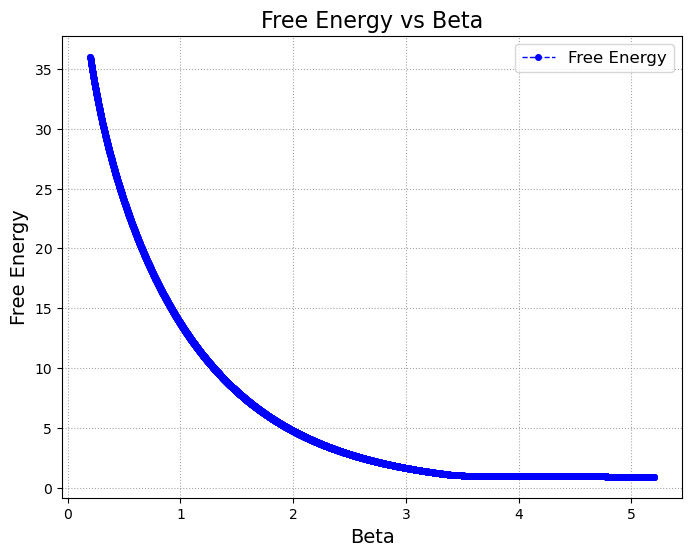

In [1401]:
# Plot Free Energy vs. Beta
plt.figure(figsize=(8,6))  # Adjust the figure size

# Customizing the line and markers
plt.plot(
    beta_array, Free_energy,
    color="blue", linestyle="--", linewidth=1, marker=".", markersize=8, label="Free Energy"
)

# Adding labels, title, and grid
plt.title("Free Energy vs Beta", fontsize=16)
plt.xlabel("Beta", fontsize=14)
plt.ylabel("Free Energy", fontsize=14)
plt.grid(color="gray", linestyle=":", linewidth=0.8, alpha=0.7)

# Customizing the legend
plt.legend(fontsize=12, loc="upper right")

# Show the plot
plt.show()


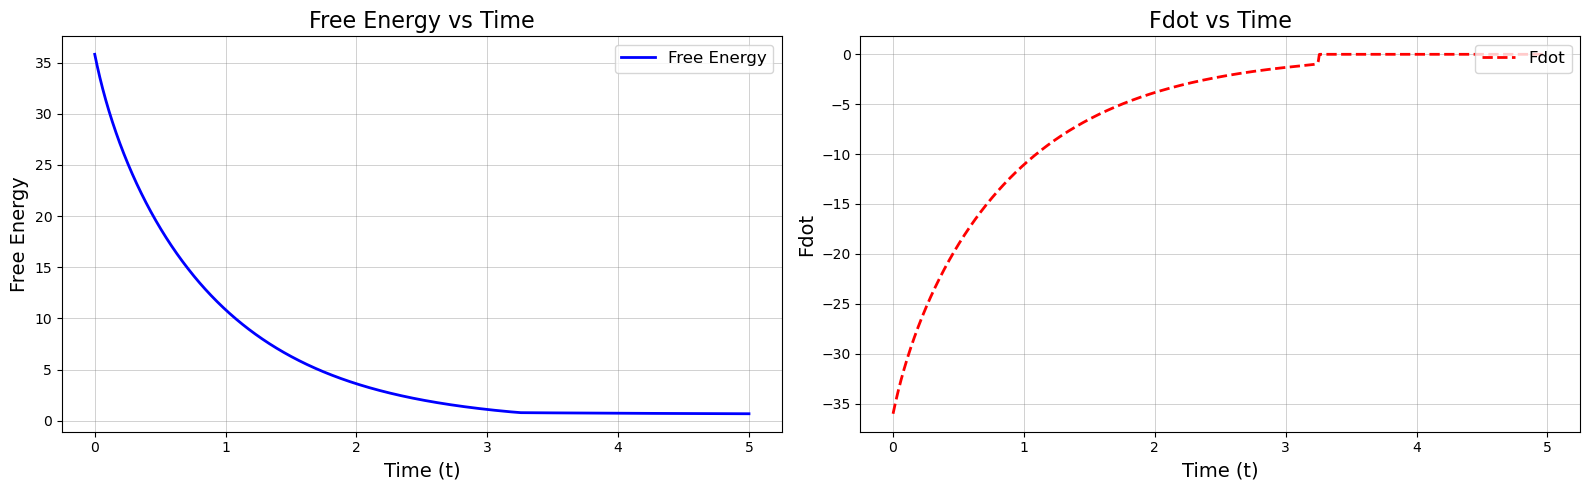

In [1402]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16,5))  # Two subplots, one column

# Plot Free Energy vs. Time in the first subplot
axs[0].plot(
    times, Free_energy - 1/beta * np.log(m),
    color="blue", linestyle="-", linewidth=2, label="Free Energy"
)
axs[0].set_title("Free Energy vs Time", fontsize=16)
axs[0].set_xlabel("Time (t)", fontsize=14)
axs[0].set_ylabel("Free Energy", fontsize=14)
axs[0].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.5)
axs[0].legend(fontsize=12, loc="upper right")

# Plot Fdot vs. Time in the second subplot
axs[1].plot(
    times, Fdot,
    color="red", linestyle="--", linewidth=2, label="Fdot"
)
axs[1].set_title("Fdot vs Time", fontsize=16)
axs[1].set_xlabel("Time (t)", fontsize=14)
axs[1].set_ylabel("Fdot", fontsize=14)
axs[1].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.5)
axs[1].legend(fontsize=12, loc="upper right")

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [1403]:
ind = -1 # Frame index
F_frame, Fdot_frame = F_Fdot_clustering_ver2(X_init, Y_traj[:,:,ind], q, u_y_traj[:,:,ind], u_b, beta_array[ind])
print('F = ', F_frame - 1/beta * np.log(m), 'and Fdot = ', Fdot_frame.value)

F =  0.6903782713326694 and Fdot =  1.0695396390214101e-33


In [1404]:
X_expanded_f = np.expand_dims(X_init, 1)       # Shape (N, 1, 2)
Y_expanded_f = np.expand_dims(Y_traj[:,:,ind], 0)       # Shape (1, m, 2)
# Y_expanded_f = np.expand_dims(np.mean(X_init,axis = 0)*np.ones((m,2)), 0)       # Shape (1, m, 2)
distances_f = np.sqrt(np.sum((X_expanded_f - Y_expanded_f) ** 2, axis=2))
distances_n_f = distances_f - np.min(distances_f, axis = 1).reshape(-1,1)
Px = np.diag(q)
beta_f = beta_array[ind]
P_ylx_G_f = np.exp(-beta_f * distances_n_f)/(np.sum(np.exp(-beta_f * distances_n_f),axis = 1).reshape(-1,1))
Py_f = np.sum(Px @ P_ylx_G_f, axis = 0)
dFdY_f = 2 * (Py_f[:, np.newaxis] * Y - P_ylx_G_f.T @ Px @ X_init)
print('dF/dY = ', dFdY_f)

dF/dY =  [[-4.64856331e-08 -5.03223241e-08]
 [-1.19168556e-07 -1.74570517e-07]
 [ 8.69333032e-08 -9.67317293e-08]]


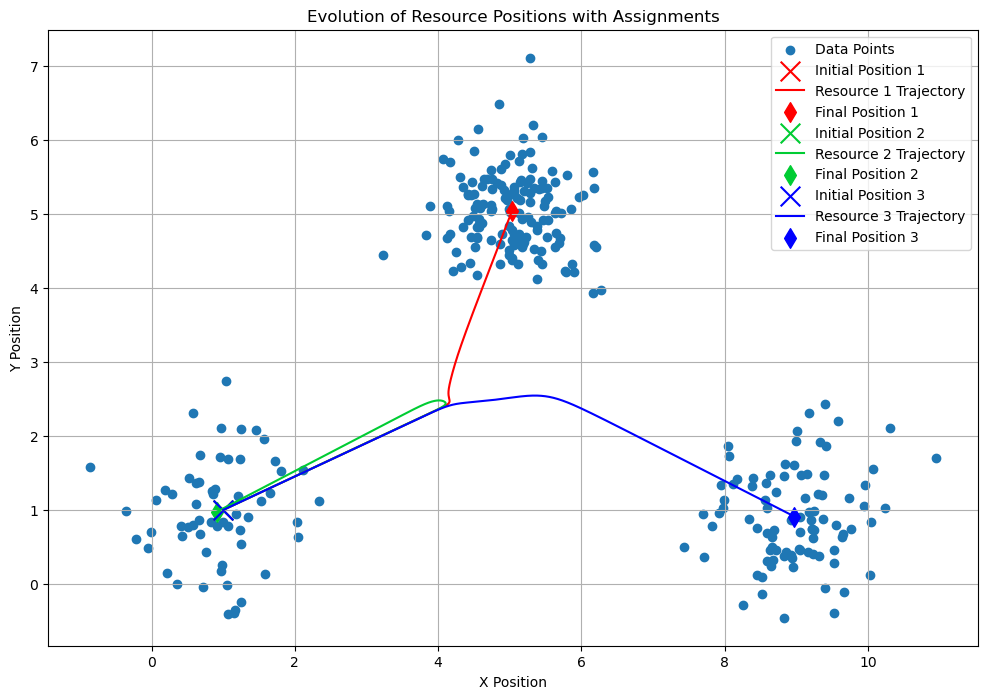

In [1405]:
# Define a color for each resource (RGB values)
resource_colors = np.array([
    [1, 0, 0],  # Red for resource 1
    [0, 0.8, 0.2],  # Green for resource 2
    [0, 0, 1],  # Blue for resource 3
])

# Plot setup
plt.figure(figsize=(12, 8))

# Plot data points with computed colors
plt.scatter(X_init[:, 0], X_init[:, 1], label="Data Points")

# Plot trajectories and final positions of resources
for i in range(m):
    # Mark initial positions of resources
    plt.scatter(
        Y_traj[i, 0, 0], Y_traj[i, 1, 0],
        marker="x", s=200, color=resource_colors[i], label=f"Initial Position {i+1}"
    )
    plt.plot(
        Y_traj[i, 0, :], Y_traj[i, 1, :],
        label=f"Resource {i+1} Trajectory", linestyle="-", color=resource_colors[i]
    )
    # Mark final positions of resources
    plt.scatter(
        Y_traj[i, 0, -1], Y_traj[i, 1, -1],
        marker="d", s=100, color=resource_colors[i], label=f"Final Position {i+1}"
    )

# Customize the plot
plt.title("Evolution of Resource Positions with Assignments")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig("resource_positions.png", dpi=300, bbox_inches='tight')

In [1406]:
Y_test = Y_traj[:,:,-1]

In [1407]:
Y_test

array([[5.02930076, 5.03570908],
       [0.91158564, 0.97645241],
       [8.97359549, 0.91105199]])

Plot frames

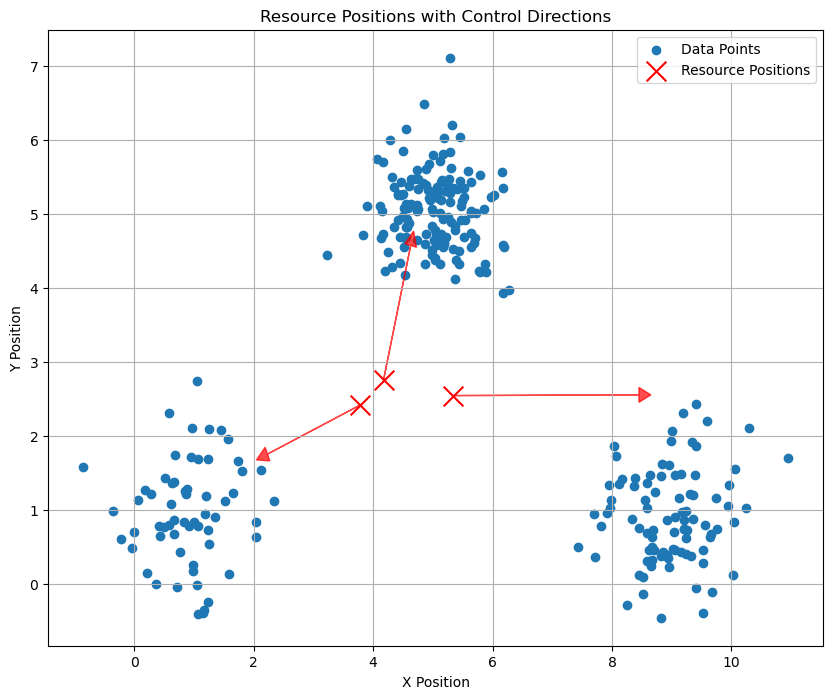

In [1408]:
ind = 1000 # Frame index

# Normalize the control vectors to have a length of l
l = 1
# u_y_frame = l * u_y_traj[:,:,ind] / np.linalg.norm(u_y_traj[:,:,ind], axis=1, keepdims=True)
u_y_frame = u_y_traj[:,:,ind]

# Plot resource positions and control arrows
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X_init[:, 0], X_init[:, 1], label='Data Points')
plt.scatter(Y_traj[:, 0, ind], Y_traj[:, 1, ind], color="red", label="Resource Positions", s=200, marker="x")

# Add arrows for control directions
for i in range(Y_traj[:,:,ind].shape[0]):  # Iterate over all resources
    plt.arrow(
        Y_traj[i,0,ind], Y_traj[i,1,ind],               # Starting point of the arrow (resource position)
        u_y_frame[i, 0], u_y_frame[i, 1],  # Arrow direction (normalized control vector)
        head_width=0.2, head_length=0.2, fc="red", ec="red", alpha=0.7
    )

# Customize the plot
plt.title("Resource Positions with Control Directions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()